<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

## 4D Analytics using the New York City Taxi dataset
</header>

### Introduction

This is a demonstration of Vantage capabilities for
- Time series, using the PERIOD data type, CONTAINS, OVERLAPS and EXPAND
- Geospatial using the ST_GEOMETRY data type and ST_SphericalDistance method

## Get Data from Network Optimized Storage (NOS)
This demonstration uses the **TRNG_NYCTaxi** database which we are providing on Network Optimized Storage (NOS).  Click the link below to access that data as a foreign table directly from NOS, or to import the data for faster performance.

[Data Dictionary](../Data_Dictionary/Data_Dictionary.ipynb#details)

## Connect Vantage and explore the dataset
We will connect the Vantage system and locate our demo dataset for this exercise.

In [1]:
%connect local

Password: ····


Success: 'local' connection established and activated for user 'demo_user'


This demonstration will use two tables: the taxi trip details and the fares for each trip. The queries below will sample each table and then show the range of the time period covered by the data. 

In [2]:
SELECT top 10 * from TRNG_NYCTaxi.trip;

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
1,6E65F6BB3F11995546EC97C379FC95A5,0707FE2829B2D61DDADE70F435141E11,CMT,1,N,2013-11-10 06:18:33.000000,2013-11-10 06:32:58.000000,2,864,2,-73.993813,40.732845,-74.00824,40.748791
2,7376BAC10BB8455E4AE6A7C3C4552458,3B55CAD7F5163FDD88E1087040D95DBB,VTS,1,,2013-11-09 19:33:00.000000,2013-11-09 20:07:00.000000,1,2040,6.32,-73.980499,40.769043,-73.901962,40.770042
3,7376BAC10BB8455E4AE6A7C3C4552458,3B55CAD7F5163FDD88E1087040D95DBB,VTS,1,,2013-11-09 20:23:00.000000,2013-11-09 20:39:00.000000,1,960,6.94,-73.987572,40.718502,-73.883324,40.743198
4,A05474051BADB7DD226F6117184BAD7B,AD956C6F205285B4DA3919824ABD04D8,VTS,1,,2013-11-10 02:55:00.000000,2013-11-10 03:04:00.000000,1,540,2.24,-73.954437,40.764084,-73.942154,40.790588
5,A05474051BADB7DD226F6117184BAD7B,AD956C6F205285B4DA3919824ABD04D8,VTS,1,,2013-11-10 03:24:00.000000,2013-11-10 03:43:00.000000,1,1140,9.25,-73.989815,40.747086,-73.873466,40.774273
6,AA18461811E697846E6F664F347FDC34,C07126B66DD215DCFEB9D48BB505212C,VTS,1,,2013-11-09 20:47:00.000000,2013-11-09 21:11:00.000000,1,1440,4.96,-73.987869,40.718601,-73.98912,40.768719
7,AA18461811E697846E6F664F347FDC34,C07126B66DD215DCFEB9D48BB505212C,VTS,1,,2013-11-09 23:58:00.000000,2013-11-10 00:17:00.000000,1,1140,15.62,-73.776817,40.645981,-73.948654,40.714153
8,AA18461811E697846E6F664F347FDC34,C07126B66DD215DCFEB9D48BB505212C,VTS,1,,2013-11-10 00:35:00.000000,2013-11-10 00:54:00.000000,1,1140,5.82,-73.99044,40.730656,-73.957787,40.801037
9,A05474051BADB7DD226F6117184BAD7B,AD956C6F205285B4DA3919824ABD04D8,VTS,1,,2013-11-10 03:07:00.000000,2013-11-10 03:20:00.000000,1,780,4.48,-73.947884,40.790009,-73.992844,40.743176
10,7376BAC10BB8455E4AE6A7C3C4552458,3B55CAD7F5163FDD88E1087040D95DBB,VTS,1,,2013-11-09 18:45:00.000000,2013-11-09 19:23:00.000000,1,2280,6.79,-73.988373,40.718689,-73.969109,40.795448


In [3]:
SELECT top 10 * from TRNG_NYCTaxi.trip_fare;

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
1,6E65F6BB3F11995546EC97C379FC95A5,0707FE2829B2D61DDADE70F435141E11,CMT,2013-11-10 06:00:21.000000,CSH,7.5,0,0.5,0,0,8
2,43FE458F8739C22C9CED57A4221148C8,3DAD33C4E0618C69AB98F2E95410ED64,VTS,2013-11-09 19:59:00.000000,CRD,17,0.5,0.5,2,0,20
3,43FE458F8739C22C9CED57A4221148C8,3DAD33C4E0618C69AB98F2E95410ED64,VTS,2013-11-09 20:17:00.000000,CRD,6,0.5,0.5,1.62,0,8.62
4,7376BAC10BB8455E4AE6A7C3C4552458,3B55CAD7F5163FDD88E1087040D95DBB,VTS,2013-11-09 19:33:00.000000,CSH,26.5,0.5,0.5,0,0,27.5
5,7376BAC10BB8455E4AE6A7C3C4552458,3B55CAD7F5163FDD88E1087040D95DBB,VTS,2013-11-09 20:50:00.000000,CRD,12.5,0.5,0.5,1.5,0,15
6,AA18461811E697846E6F664F347FDC34,C07126B66DD215DCFEB9D48BB505212C,VTS,2013-11-09 20:47:00.000000,CRD,21,0.5,0.5,4.3,0,26.3
7,AA18461811E697846E6F664F347FDC34,C07126B66DD215DCFEB9D48BB505212C,VTS,2013-11-09 23:58:00.000000,CRD,41.5,0.5,0.5,3,0,45.5
8,AA18461811E697846E6F664F347FDC34,C07126B66DD215DCFEB9D48BB505212C,VTS,2013-11-10 00:35:00.000000,CRD,20.5,0.5,0.5,4.2,0,25.7
9,7376BAC10BB8455E4AE6A7C3C4552458,3B55CAD7F5163FDD88E1087040D95DBB,VTS,2013-11-09 20:23:00.000000,CSH,22.5,0.5,0.5,0,0,23.5
10,43FE458F8739C22C9CED57A4221148C8,3DAD33C4E0618C69AB98F2E95410ED64,VTS,2013-11-09 19:31:00.000000,CSH,11,0.5,0.5,0,0,12


In [4]:
sel min(pickup_datetime), max(dropoff_datetime) from TRNG_NYCTaxi.trip;

,pickup_datetime,dropoff_datetime
1,2013-11-09 17:19:44.000000,2013-11-10 20:36:03.000000


## Warmup: temporal algebra 
<img  src="contains.png" alt="Contains Example" width="600" align="right" />
Let's warmup with a bit of temporal algebra and get familiar with period types and operators. 
<br><br>
For a taxi service, the number of dispatchers needed is impacted by the number of pickups. While some pickups are based on a taxi stand or someone waving their hand along the side of the street, the driver calls in the trip. 
<br><br>The period data type may be based on dates or timestamps and has a beginning bound and extends up to, but does not include the ending bound value. The ending bound may be expressed as "UNTIL_CHANGED" or "UNTIL CLOSED" which effectively means "forever". Most commonly, the period data type would appear in a table but in the example below, we will use a literal to count the number of taxi pickups between 10:30 and 10:45 on Nov 10th.

In [5]:
sel count(1)
from TRNG_NYCTaxi.trip  
--where pickup_datetime between '2013-11-10 10:30:00' and '2013-11-10 10:45:00'
--Here is an alternative to the above using period data type a
where period
	(
		'2013-11-10 10:30:00' (timestamp), 
		'2013-11-10 10:45:00' (timestamp)
	) 
	CONTAINS pickup_datetime 

,Count(1)
1,5736


<img  src="contains-period.png" alt="Contains Period Example" width="600" align="right" />
The above example used CONTAINS for a simple comparison to a date which is easily replaced by BETWEEN.  A more interesting case is when two periods are in a constraint which would be more complicated logic.  The following query analyzes how many rides started and ended between 10:30 and 10:45 on Nov 10th.

In [6]:
SELECT count(1)
FROM TRNG_NYCTaxi.trip  
WHERE  pickup_datetime < dropoff_datetime
and period
	(
		'2013-11-10 10:30:00' (timestamp), 
		'2013-11-10 10:45:00' (timestamp)
	) 
	contains period(pickup_datetime, dropoff_datetime);

,Count(1)
1,1738


<img  src="overlap.png" alt="Overlap Example" width="600" align="right" />
The taxi cabs now contain video screens that include advertising content. To analyze the number of people that may be viewing the video to justify compensation for advertising, we need to know how many people are in the cabs in a given period. 
<br><br>
Where the CONTAINS operator above says that the timestamp or period must be within the bounds of the period, the OVERLAPS operator selects any rows where the row's period begins, ends, or orverlaps the constraint period.  In the following example, we count how many passengers were in a taxi between 10:30 and 10:45 on Nov 10th.

In [7]:
SELECT sum(passenger_count)
FROM TRNG_NYCTaxi.trip  
WHERE pickup_datetime < dropoff_datetime
and period
	(
		'2013-11-10 10:30:00' (timestamp), 
		'2013-11-10 10:45:00' (timestamp)
	) 
	overlaps period(pickup_datetime, dropoff_datetime)
;

,passenger_count
1,20106


<img  src="normalize.png" alt="Overlap Example" width="600" align="right" />
As input to the hours of dispatch operations, management would like to know how many hours in the day there is at least 1 taxi operating.
<br><br>
Let's assume we run the fleet of the 3 taxis identifiable by medallion starting with ‘007’. The fleet is considered active if at least 1 taxi is driving. For how long has the fleet been “active” on November 10th?
<br><br>
We will need to consolidate (or normalize) the periods where taxis are active and then find the duration of the resulting periods of activity. The final query will have nested derived tables, so we will start by showing a sample of the innermost query which will create a set of periods on the date for the group of medallions:

In [8]:
SELECT top 10
period(pickup_datetime, dropoff_datetime) as norm_per
from TRNG_NYCTaxi.trip  
where (pickup_datetime (date))='2013-11-10'
and medallion like '007%'
order by 1;

,norm_per
1,"2013-11-10 00:13:04.000000,2013-11-10 00:30:10.000000"
2,"2013-11-10 02:04:45.000000,2013-11-10 02:10:52.000000"
3,"2013-11-10 02:13:00.000000,2013-11-10 02:35:00.000000"
4,"2013-11-10 02:16:20.000000,2013-11-10 02:22:33.000000"
5,"2013-11-10 02:23:30.000000,2013-11-10 02:38:48.000000"
6,"2013-11-10 02:33:34.000000,2013-11-10 02:42:08.000000"
7,"2013-11-10 02:39:52.000000,2013-11-10 02:42:41.000000"
8,"2013-11-10 02:46:00.000000,2013-11-10 02:53:00.000000"
9,"2013-11-10 03:13:00.000000,2013-11-10 03:25:00.000000"
10,"2013-11-10 03:22:21.000000,2013-11-10 03:34:30.000000"


We will then use the NORMALIZE modifier to consolidate the periods. With NORMALIZE, the result of the select is normalized on the first period column in the select list. Period values that meet or overlap are coalesced, that is, combined to form a period that
encompasses the individual period values.  For comparison, we will follow with a query that doesn't normmalize which is the total hours of active service of all of the taxis. 

In [2]:
SELECT sum(interval(normalized_periods) hour(2) to minute) (title 'normalized_activity')
from
(
	SELECT normalize
	period(pickup_datetime, dropoff_datetime) as normalized_periods
	from TRNG_NYCTaxi.trip  
	where (pickup_datetime (date))='2013-11-10'
	and medallion like '007%'
) d1
order by 1;

,normalized_activity
1,15:07


The above result shows out of the 24 hours in the day, how many hours were any taxis operating.  For comparison, the following query will sum up how many hours in the day the medalions like '007%' were carrying passenger. 

In [3]:
select sum( interval( period(pickup_datetime, dropoff_datetime) ) hour to minute ) total_activity
    from TRNG_NYCTaxi.trip  
	where (pickup_datetime (date))='2013-11-10'
	and medallion like '007%'

,total_activity
1,27:06


The normalized activity consolidating all of the periods before sumarizing is less than the total activity. 
<br><br>
There are situations where you need to see the state of the business at fixed intervals. For example: total inventory at the end of each week.  The EXPAND ON operator will create those routine periods for reporting. To demonstrate EXPAND ON, we will get a count of active cabs at the top of each hour.

In [21]:
select begin_hour, count(*)
from
(
	select begin(hour_check) begin_hour
	from TRNG_NYCTaxi.trip  
	where (pickup_datetime (date))='2013-11-10'
	and medallion like '007%'
    EXPAND ON period(pickup_datetime, dropoff_datetime) AS hour_check BY ANCHOR ANCHOR_HOUR
) a
group by 1
order by 1;

,begin_hour,Count(*)
1,2013-11-10 06:00:00.000000,3
2,2013-11-10 07:00:00.000000,1
3,2013-11-10 08:00:00.000000,2
4,2013-11-10 09:00:00.000000,2
5,2013-11-10 10:00:00.000000,1
6,2013-11-10 11:00:00.000000,1
7,2013-11-10 12:00:00.000000,1
8,2013-11-10 13:00:00.000000,3
9,2013-11-10 14:00:00.000000,2
10,2013-11-10 15:00:00.000000,2


## Time series analysis

Let's now move on to time series transformations and analytics.

### Time series analysis

Vantage supports time series analysis. The query issues a GROUP BY clause referencing a unit of time and includes a USING TIMECODE clause to specify a column that the unit grouping is to be applied to. 
How many passengers are being picked up by hour in november?

In [29]:
select extract(day from pickup_datetime), extract(hour from pickup_datetime), sum(passenger_count) 
from TRNG_NYCTaxi.trip 
where extract(month from pickup_datetime)=11
group by 1,2 order by 1,2


,pickup_datetime,pickup_datetime-1,passenger_count
1,9,17,14
2,9,18,13673
3,9,19,58635
4,9,20,51046
5,9,21,44277
6,9,22,34422
7,9,23,22054
8,10,0,9395
9,10,1,7828
10,10,2,10167


In [30]:
sel top 72
$TD_TIMECODE_RANGE 
,begin($TD_TIMECODE_RANGE) time_bucket_start --(timestamp, format 'YYYY-MM-DDBHH:MI:SS') time_bucket_start
,sum(passenger_count) passenger_count
from TRNG_NYCTaxi.trip 
where extract(month from pickup_datetime)=11
group by time(hours(1))
USING TIMECODE(pickup_datetime)
order by 1;

,TIMECODE_RANGE,time_bucket_start,passenger_count
1,"2013-11-09 17:00:00.000000-05:00,2013-11-09 18:00:00.000000-05:00",2013-11-09 17:00:00.000000-05:00,14
2,"2013-11-09 18:00:00.000000-05:00,2013-11-09 19:00:00.000000-05:00",2013-11-09 18:00:00.000000-05:00,13673
3,"2013-11-09 19:00:00.000000-05:00,2013-11-09 20:00:00.000000-05:00",2013-11-09 19:00:00.000000-05:00,58635
4,"2013-11-09 20:00:00.000000-05:00,2013-11-09 21:00:00.000000-05:00",2013-11-09 20:00:00.000000-05:00,51046
5,"2013-11-09 21:00:00.000000-05:00,2013-11-09 22:00:00.000000-05:00",2013-11-09 21:00:00.000000-05:00,44277
6,"2013-11-09 22:00:00.000000-05:00,2013-11-09 23:00:00.000000-05:00",2013-11-09 22:00:00.000000-05:00,34422
7,"2013-11-09 23:00:00.000000-05:00,2013-11-10 00:00:00.000000-05:00",2013-11-09 23:00:00.000000-05:00,22054
8,"2013-11-10 00:00:00.000000-05:00,2013-11-10 01:00:00.000000-05:00",2013-11-10 00:00:00.000000-05:00,9395
9,"2013-11-10 01:00:00.000000-05:00,2013-11-10 02:00:00.000000-05:00",2013-11-10 01:00:00.000000-05:00,7828
10,"2013-11-10 02:00:00.000000-05:00,2013-11-10 03:00:00.000000-05:00",2013-11-10 02:00:00.000000-05:00,10167


It's about time to add some visual element...

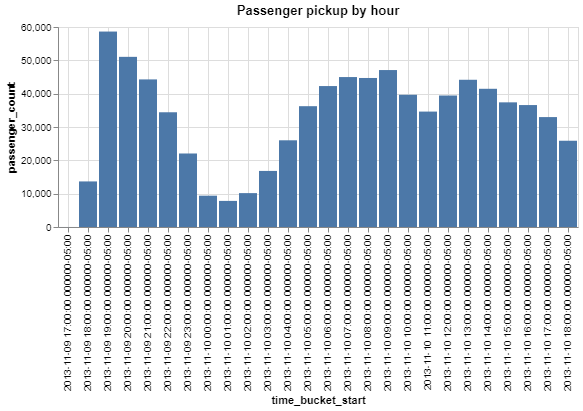

In [27]:
%chart x=time_bucket_start, y=passenger_count, title=Passenger pickup by hour

How many passengers are being picked up and what is the average trip duration by vendor every 30mn in November?

In [31]:
sel top 96
$TD_TIMECODE_RANGE 
,vendor_id
,sum(passenger_count)
,avg(trip_time_in_secs)
from TRNG_NYCTaxi.trip
group by time(minutes(15) and vendor_id)
USING TIMECODE(pickup_datetime)
where extract(month from pickup_datetime)=11
order by 1,2;

,TIMECODE_RANGE,vendor_id,PASSENGER_COUNT,TRIP_TIME_IN_SECS
1,"2013-11-09 17:15:00.000000-05:00,2013-11-09 17:30:00.000000-05:00",CMT,1,1344
2,"2013-11-09 17:30:00.000000-05:00,2013-11-09 17:45:00.000000-05:00",CMT,1,5128
3,"2013-11-09 17:45:00.000000-05:00,2013-11-09 18:00:00.000000-05:00",VTS,12,4560
4,"2013-11-09 18:00:00.000000-05:00,2013-11-09 18:15:00.000000-05:00",CMT,15,3745.5714285714284
5,"2013-11-09 18:00:00.000000-05:00,2013-11-09 18:15:00.000000-05:00",VTS,21,3425.4545454545455
6,"2013-11-09 18:15:00.000000-05:00,2013-11-09 18:30:00.000000-05:00",CMT,91,2508.8166666666666
7,"2013-11-09 18:15:00.000000-05:00,2013-11-09 18:30:00.000000-05:00",VTS,176,2572.1428571428573
8,"2013-11-09 18:30:00.000000-05:00,2013-11-09 18:45:00.000000-05:00",CMT,931,1655.879661016949
9,"2013-11-09 18:30:00.000000-05:00,2013-11-09 18:45:00.000000-05:00",VTS,1360,1673.446153846154
10,"2013-11-09 18:45:00.000000-05:00,2013-11-09 19:00:00.000000-05:00",CMT,4450,962.5166380789022


Let's call this a view

In [32]:
replace view NYC_taxi_trip_ts as
sel
$TD_TIMECODE_RANGE time_bucket_per
,vendor_id
,sum(passenger_count) passenger_cnt
,sum(trip_time_in_secs) avg_trip_time_in_secs
from TRNG_NYCTaxi.trip 
group by time(minutes(15) and vendor_id)
USING TIMECODE(pickup_datetime)
where extract(month from pickup_datetime)=11;

Success: 0 rows affected

### Moving Averages

Let's calculate a 2 hours minutes moving average on our 15-minutes time series. 2 hour is 8 * 15 minutes periods.

In [33]:
SELECT * FROM MovingAverage (
  ON NYC_taxi_trip_ts PARTITION BY vendor_id ORDER BY time_bucket_per
  USING
  MAvgType ('S')
  WindowSize (8)
  TargetColumns ('passenger_cnt')
) AS dt 
where begin(time_bucket_per)(date) = '2013-11-10'
ORDER BY vendor_id, time_bucket_per;

,time_bucket_per,vendor_id,passenger_cnt,avg_trip_time_in_secs,passenger_cnt_smavg
1,"2013-11-10 00:00:00.000000-05:00,2013-11-10 00:15:00.000000-05:00",CMT,1000,518198,2452.5
2,"2013-11-10 00:15:00.000000-05:00,2013-11-10 00:30:00.000000-05:00",CMT,944,492988,2123.5
3,"2013-11-10 00:30:00.000000-05:00,2013-11-10 00:45:00.000000-05:00",CMT,878,476111,1835
4,"2013-11-10 00:45:00.000000-05:00,2013-11-10 01:00:00.000000-05:00",CMT,859,457154,1541
5,"2013-11-10 01:00:00.000000-05:00,2013-11-10 01:15:00.000000-05:00",CMT,768,425882,1252.75
6,"2013-11-10 01:15:00.000000-05:00,2013-11-10 01:30:00.000000-05:00",CMT,797,416427,1049.25
7,"2013-11-10 01:30:00.000000-05:00,2013-11-10 01:45:00.000000-05:00",CMT,839,460462,927.5
8,"2013-11-10 01:45:00.000000-05:00,2013-11-10 02:00:00.000000-05:00",CMT,832,462800,864.625
9,"2013-11-10 02:00:00.000000-05:00,2013-11-10 02:15:00.000000-05:00",CMT,931,484578,856
10,"2013-11-10 02:15:00.000000-05:00,2013-11-10 02:30:00.000000-05:00",CMT,912,507263,852


We can use this to identify demand trends for each time period. A basic way to do this would be to check if the current pickup count is above (rising) or below (reducing) our moving average.

In [ ]:
SELECT time_bucket_per, vendor_id, passenger_cnt, trend, case when passenger_cnt - passenger_cnt_smavg > 0 then '+' else '-' end trend
FROM MovingAverage (
  ON NYC_taxi_trip_ts PARTITION BY vendor_id ORDER BY time_bucket_per
  USING
  MAvgType ('S')
  WindowSize (8)
  TargetColumns ('passenger_cnt')
) AS dt 
where begin(time_bucket_per)(date) = '2013-11-10'
ORDER BY vendor_id, time_bucket_per;

We can use this to compare how vendors are doing.

In [34]:
sel dt.*
from 
(
	SELECT time_bucket_per, vendor_id, passenger_cnt, case when passenger_cnt - passenger_cnt_smavg > 0 then '+' else '-' end trend
	FROM MovingAverage (
	  ON NYC_taxi_trip_ts PARTITION BY vendor_id ORDER BY time_bucket_per
	  USING
	  MAvgType ('S')
	  WindowSize (8)
	  TargetColumns ('passenger_cnt')
	) AS dt 
	where begin(time_bucket_per)(date) = '2013-11-10'
) dt
PIVOT(
    MAX(passenger_cnt) as passenger_cnt, MAX(trend) as trend FOR vendor_id IN ('CMT', 'VTS')
) dt
order by 1;

,time_bucket_per,'CMT'_passenger_cnt,'CMT'_trend,'VTS'_passenger_cnt,'VTS'_trend
1,"2013-11-10 00:00:00.000000-05:00,2013-11-10 00:15:00.000000-05:00",1000,-,1711,-
2,"2013-11-10 00:15:00.000000-05:00,2013-11-10 00:30:00.000000-05:00",944,-,1426,-
3,"2013-11-10 00:30:00.000000-05:00,2013-11-10 00:45:00.000000-05:00",878,-,1350,-
4,"2013-11-10 00:45:00.000000-05:00,2013-11-10 01:00:00.000000-05:00",859,-,1227,-
5,"2013-11-10 01:00:00.000000-05:00,2013-11-10 01:15:00.000000-05:00",768,-,1205,-
6,"2013-11-10 01:15:00.000000-05:00,2013-11-10 01:30:00.000000-05:00",797,-,1024,-
7,"2013-11-10 01:30:00.000000-05:00,2013-11-10 01:45:00.000000-05:00",839,-,1258,-
8,"2013-11-10 01:45:00.000000-05:00,2013-11-10 02:00:00.000000-05:00",832,-,1105,-
9,"2013-11-10 02:00:00.000000-05:00,2013-11-10 02:15:00.000000-05:00",931,+,1170,-
10,"2013-11-10 02:15:00.000000-05:00,2013-11-10 02:30:00.000000-05:00",912,+,1200,+


### Geospatial analysis

Let's define a few landmarks.

In [ ]:
CREATE VOLATILE TABLE dim_geo_locations
     (
      location VARCHAR(100),
      Lat FLOAT,
      Lon FLOAT,
      geo_point SYSUDTLIB.ST_GEOMETRY(16776192) INLINE LENGTH 9920)
PRIMARY INDEX ( location )
ON COMMIT PRESERVE ROWS;

In [ ]:
insert into dim_geo_locations values('Columbia University',40.81,-73.96,'POINT(40.81 -73.96)');
insert into dim_geo_locations values('Empire State Building',40.75,-73.99,'POINT(40.75 -73.99)');
insert into dim_geo_locations values('Grand Central Station',40.75,-73.98,'POINT(40.75 -73.98)');
insert into dim_geo_locations values('JFK Airport',40.64,-73.79,'POINT(40.64 -73.79)');
insert into dim_geo_locations values('Madison Square Garden',40.75,-73.99,'POINT(40.75 -73.99)');
insert into dim_geo_locations values('New York Stock Exchange',40.71,-74.01,'POINT(40.71 -74.01)');
insert into dim_geo_locations values('Times Square',40.76,-73.99,'POINT(40.76 -73.99)');
insert into dim_geo_locations values('United Nations HQ',40.75,-73.97,'POINT(40.75 -73.97)');
insert into dim_geo_locations values('Yankee Stadium',40.83,-73.93,'POINT(40.83 -73.93)');

We are casting coordinates as a ST_GEOMETRY type. Here are the coordinates for the Yankee Stadium, and this is a point:

In [ ]:
sel cast('POINT(40.75 -73.97)' as ST_GEOMETRY)

Let's filter amd label the rides starting within 1km from a given landmark.

In [ ]:
sel
l.location
,cast('POINT('||trim(r.pickup_latitude (Decimal(15,6)))||' '||trim(r.pickup_longitude (Decimal(15,6)))||')' as ST_GEOMETRY) pickup_point
,r.*
from TRNG_NYCTaxi.trip r
join dim_geo_locations l
    on pickup_point.ST_SphericalDistance(l.geo_point)<1000
where (r.pickup_datetime (date)) = '2013-11-10'
;

What is the number of pickup at each location throughout the month?

In [ ]:
sel
$TD_TIMECODE_RANGE time_bucket_per
,l.location
,count(1) pickup_cnt
from TRNG_NYCTaxi.trip r
join dim_geo_locations l
	on cast('POINT('||trim(r.pickup_latitude (Decimal(15,6)))||' '||trim(r.pickup_longitude (Decimal(15,6)))||')' as ST_GEOMETRY).ST_SphericalDistance(l.geo_point)<1000
group by time(minutes(15) and l.location)
USING TIMECODE(pickup_datetime)
where extract(month from pickup_datetime)=11
order by 2,1;

What is the average demand at each location throughout the day, based on November data?

In [ ]:
sel *
from 
(
	sel
	begin($TD_TIMECODE_RANGE) (time) timeOfDay
	,l.location
	,count(1) pickup_cnt
	from TRNG_NYCTaxi.trip r
	join dim_geo_locations l
		on cast('POINT('||trim(r.pickup_latitude (Decimal(15,6)))||' '||trim(r.pickup_longitude (Decimal(15,6)))||')' as ST_GEOMETRY).ST_SphericalDistance(l.geo_point)<1000
	group by time(minutes(15) and l.location)
	USING TIMECODE(pickup_datetime)
	where extract(month from pickup_datetime)=11
) AS dt 
PIVOT(
    avg(pickup_cnt) FOR location IN (sel distinct location from dim_geo_locations)
) dt
order by 1;

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2020 Teradata. All Rights Reserved</footer>